In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [2]:
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

print("Till now all OK...")

Till now all OK...


In [3]:
#path = 'D:\Research Related\ICMIA 23 Paper\depresjon\condition\condition_'
path = 'E:\depresjon\condition\condition_'
sequences = list()

i = 0
while True:
    i +=1
    try:
        file_path = path + str(i) + '.csv'
        df = pd.read_csv(file_path, header=0, usecols = ['activity'])
        values = df.values
        sequences.append(values)
    except FileNotFoundError:
            break
            
ncf = len(sequences)
print("Total condition data:", ncf)

#path = 'C:\datasets\depresjon\control\control_'
path = 'E:\depresjon\control\control_'
i = 0
while True:
    i +=1
    try:
        file_path = path + str(i) + '.csv'
        df = pd.read_csv(file_path, header=0, usecols = ['activity'])
        values = df.values
        sequences.append(values)
    except FileNotFoundError:
            break
ncof = len(sequences) - ncf
print("Number of control data: ", ncof)
print("Total number of files: ",  len(sequences))

Total condition data: 23
Number of control data:  32
Total number of files:  55


In [4]:
#targets = pd.read_csv('D:\Research Related\ICMIA 23 Paper\depresjon\scores.csv')
targets = pd.read_csv('E:\depresjon\scores.csv')
targets = targets.values[:,-1]

In [5]:
#groups = pd.read_csv('C:\datasets\AAL\groups\MovementAAL_DatasetGroup.csv', header=0)
groups = targets
print(groups)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count       55.000000
mean     28576.472727
std      10711.258367
min      19299.000000
25%      21662.000000
50%      23244.000000
75%      31479.000000
max      65407.000000
dtype: float64

In [7]:
#Padding the sequence with the values in last row to max length
final_seq = sequences
#truncate the sequence to length 20000

from tensorflow.keras.preprocessing import sequence
seq_len = 21000
final_seq=sequence.pad_sequences(final_seq, 
                                 maxlen=seq_len, padding='post', 
                                 dtype='float', truncating='post')

In [8]:
from sklearn.model_selection import train_test_split

train, test, train_target, test_target = train_test_split(
    final_seq, targets, test_size=0.2, random_state=1)
train, validation, train_target, validation_target = train_test_split(
    train, train_target, test_size=0.25, random_state=1)

print("Total train data: ",len(train[0]))
print("Total test data: ",len(test[0]))
print("Total validation data:",len(validation[0]))

print("Total train data: ",len(train_target))
print("Total test data: ",len(test_target))
print("Total validation data:",len(validation_target))

Total train data:  21000
Total test data:  21000
Total validation data: 21000
Total train data:  33
Total test data:  11
Total validation data: 11


In [9]:
from sklearn.preprocessing import MinMaxScaler

for i in range(len(train)):
    train[i] = train[i].reshape((len(train[i]), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train[i])
    train[i] = scaler.transform(train[i])
#print(train[0])

for i in range(len(test)):
    test[i] = test[i].reshape((len(test[i]), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(test[i])
    test[i] = scaler.transform(test[i])
    
for i in range(len(validation)):
    validation[i] = validation[i].reshape((len(validation[i]), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(validation[i])
    validation[i] = scaler.transform(validation[i])
    
print("Till now all OK...")

Till now all OK...


In [10]:
train = np.asarray(train).astype(np.float32)
validation = np.asarray(validation).astype(np.float32)
test = np.asarray(test).astype(np.float32)

train_target = np.asarray(train_target).astype(np.float32)
validation_target = np.asarray(validation_target).astype(np.float32)
test_traget = np.asarray(test_target).astype(np.float32)

print("Till now all OK...")

Till now all OK...


In [11]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(seq_len, 1)))
model.add(GRU(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

print("Till now all OK...")

Till now all OK...


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21000, 32)         3360      
                                                                 
 gru_1 (GRU)                 (None, 21000, 16)         2400      
                                                                 
 gru_2 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6393 (24.97 KB)
Trainable params: 6393 (24.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001) # callbacks=[chk],
#chk = ModelCheckpoint(r'C:\Users\psbis\OneDrive\Desktop\Research on Stress\Stress 1 research\depresjon\best_model.pkl', 
                      #monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train, train_target, epochs= 2, batch_size= 11, validation_data=(validation,validation_target))

print("Training is complete.")

Epoch 1/2
3/3 [==============================] - 322s 107s/step - loss: 0.6909 - accuracy: 0.6061 - val_loss: 0.7059 - val_accuracy: 0.2727
Epoch 2/2
3/3 [==============================] - 318s 108s/step - loss: 0.6891 - accuracy: 0.6061 - val_loss: 0.7164 - val_accuracy: 0.2727
Training is complete.


In [14]:
#loading the model and checking accuracy on the test data
#model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
#test_preds = model.predict_classes(test)

#test_preds = model.predict(test)
#classes_x=np.argmax(test_preds,axis=1)

#correction

test_preds = (model.predict(test) > 0.5).astype("int32")

test_preds = test_preds.flatten()
print(type(test_preds.flatten()))
print(type(test_target))

print((test_preds.flatten()))
print((test_target))

#accuracy_score(test_target, test_preds, normalize=False)

1/1 [==============================] - 6s 6s/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 0]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


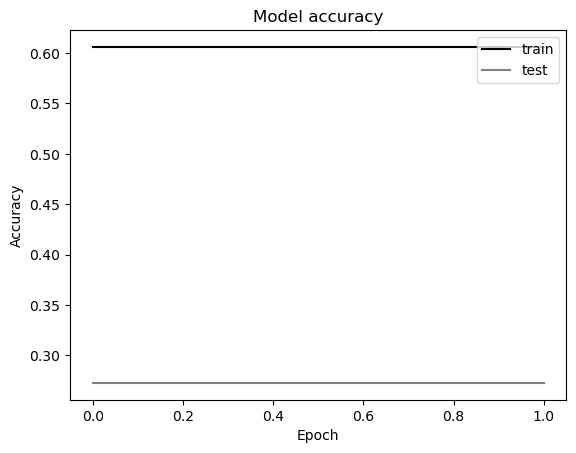

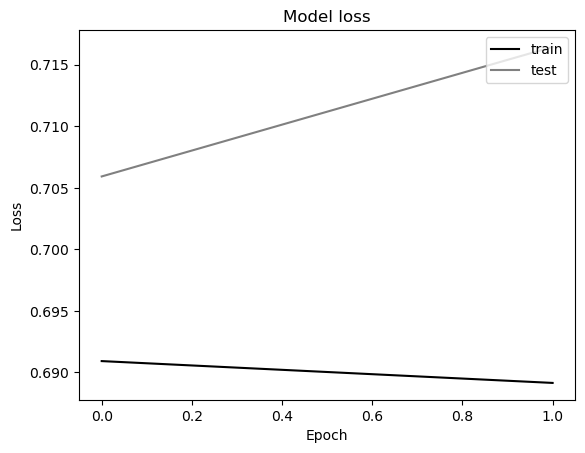

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], linestyle = '-', color="black")
plt.plot(history.history['val_accuracy'], color= 'gray')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color="black")
plt.plot(history.history['val_loss'],color= 'gray')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()